In [ ]:
# Perform Google Colab installs (if running in Google Colab)
import os

if "COLAB_GPU" in os.environ:
    print("[INFO] Running in Google Colab, installing requirements.")
    !pip install -U torch # requires torch 2.1.1+ (for efficient sdpa implementation)
    !pip install PyMuPDF # for reading PDFs with Python
    !pip install tqdm # for progress bars
    !pip install sentence-transformers # for embedding models
    !pip install accelerate # for quantization model loading
    !pip install bitsandbytes # for quantizing models (less storage space)
    !pip install flash-attn --no-build-isolation # for faster attention mechanism = faster LLM inference

[INFO] Running in Google Colab, installing requirements.


# **1. Document/Text Processing and Embedding Creation:**

In [ ]:
# Download PDF file
import os
import requests

# Get PDF document
pdf_path = "human-nutrition-text.pdf"

# Download PDF if it doesn't already exist
if not os.path.exists(pdf_path):
  print("File doesn't exist, downloading...")

  # The URL of the PDF you want to download
  url = "https://pressbooks.oer.hawaii.edu/humannutrition2/open/download?type=pdf"

  # The local filename to save the downloaded file
  filename = pdf_path

  # Send a GET request to the URL
  response = requests.get(url)

  # Check if the request was successful
  if response.status_code == 200:
      # Open a file in binary write mode and save the content to it
      with open(filename, "wb") as file:
          file.write(response.content)
      print(f"The file has been downloaded and saved as {filename}")
  else:
      print(f"Failed to download the file. Status code: {response.status_code}")
else:
  print(f"File {pdf_path} exists.")

File human-nutrition-text.pdf exists.


### **1.1. A small helper function to preprocess the text as it gets read:**

#### **Collecting Page Statistics:**

A dictionary is created for each page with the following key-value pairs:

- **`"page_number"`**: Adjusted page number (since the PDF starts on page 42, the page number is adjusted by subtracting 41).
- **`"page_char_count"`**: The number of characters in the text (`len(text)`).
- **`"page_word_count"`**: The number of words in the text (`len(text.split(" "))`), where words are assumed to be separated by spaces.
- **`"page_sentence_count_raw"`**: The number of sentences in the text (`len(text.split(". "))`), where sentences are assumed to be separated by periods followed by spaces.
- **`"page_token_count"`**: The estimated number of tokens in the text (`len(text) / 4`), based on the approximation that 1 token is about 4 characters.
- **`"text"`**: The extracted and formatted text.


In [ ]:
# Requires !pip install PyMuPDF, see: https://github.com/pymupdf/pymupdf
import fitz # (pymupdf, found this is better than pypdf for our use case, note: licence is AGPL-3.0, keep that in mind if you want to use any code commercially)
from tqdm.auto import tqdm # for progress bars, requires !pip install tqdm

def text_formatter(text: str) -> str:
    """Performs minor formatting on text."""
    cleaned_text = text.replace("\n", " ").strip() # note: this might be different for each doc (best to experiment)

    # Other potential text formatting functions can go here
    return cleaned_text

# Open PDF and get lines/pages
# Note: this only focuses on text, rather than images/figures etc
def open_and_read_pdf(pdf_path: str) -> list[dict]:
    """
    Opens a PDF file, reads its text content page by page, and collects statistics.

    Parameters:
        pdf_path (str): The file path to the PDF document to be opened and read.

    Returns:
        list[dict]: A list of dictionaries, each containing the page number
        (adjusted), character count, word count, sentence count, token count, and the extracted text
        for each page.
    """
    doc = fitz.open(pdf_path)  # open a document
    pages_and_texts = []
    for page_number, page in tqdm(enumerate(doc)):  # iterate the document pages
        text = page.get_text()  # get plain text encoded as UTF-8
        text = text_formatter(text)
        pages_and_texts.append({"page_number": page_number - 41,  # adjust page numbers since our PDF starts on page 42
                                "page_char_count": len(text),
                                "page_word_count": len(text.split(" ")),
                                "page_sentence_count_raw": len(text.split(". ")),
                                "page_token_count": len(text) / 4,  # 1 token = ~4 chars, see: https://help.openai.com/en/articles/4936856-what-are-tokens-and-how-to-count-them
                                "text": text})
    return pages_and_texts

pages_and_texts = open_and_read_pdf(pdf_path=pdf_path)
pages_and_texts[:2]

0it [00:00, ?it/s]

[{'page_number': -41,
  'page_char_count': 29,
  'page_word_count': 4,
  'page_sentence_count_raw': 1,
  'page_token_count': 7.25,
  'text': 'Human Nutrition: 2020 Edition'},
 {'page_number': -40,
  'page_char_count': 0,
  'page_word_count': 1,
  'page_sentence_count_raw': 1,
  'page_token_count': 0.0,
  'text': ''}]

In [ ]:
import random

random.sample(pages_and_texts, k=3)

[{'page_number': 728,
  'page_char_count': 123,
  'page_word_count': 27,
  'page_sentence_count_raw': 1,
  'page_token_count': 30.75,
  'text': 'Image by  FDA/  Changes to  the Nutrition  Facts Label  Figure 12.5 Food Serving Sizes  728  |  Discovering Nutrition Facts'},
 {'page_number': -38,
  'page_char_count': 212,
  'page_word_count': 32,
  'page_sentence_count_raw': 1,
  'page_token_count': 53.0,
  'text': 'Human Nutrition: 2020 Edition by University of Hawai‘i at Mānoa Food Science and  Human Nutrition Program is licensed under a Creative Commons Attribution 4.0  International License, except where otherwise noted.'},
 {'page_number': 491,
  'page_char_count': 765,
  'page_word_count': 124,
  'page_sentence_count_raw': 4,
  'page_token_count': 191.25,
  'text': 'Learning Activities  Technology Note: The second edition of the Human  Nutrition Open Educational Resource (OER) textbook  features interactive learning activities.\xa0 These activities are  available in the web-based tex

### **1.2. Get some statistics on text:**

In [ ]:
import pandas as pd

df = pd.DataFrame(pages_and_texts)
df.head(10)

,page_number,page_char_count,page_word_count,page_sentence_count_raw,page_token_count,text
0,-41,29,4,1,7.25,Human Nutrition: 2020 Edition
1,-40,0,1,1,0.00,
2,-39,320,54,1,80.00,Human Nutrition: 2020 Edition UNIVERSITY OF ...
3,-38,212,32,1,53.00,Human Nutrition: 2020 Edition by University of...
4,-37,797,145,2,199.25,Contents Preface University of Hawai‘i at Mā...
5,-36,976,177,2,244.00,Lifestyles and Nutrition University of Hawai‘...
6,-35,1037,191,1,259.25,The Cardiovascular System University of Hawai...
7,-34,1047,186,2,261.75,"Indicators of Health: Body Mass Index, Body Fa..."
8,-33,947,168,2,236.75,Chloride University of Hawai‘i at Mānoa Food ...
9,-32,1024,187,2,256.00,The Functions of Carbohydrates in the Body Un...


In [ ]:
# Get stats
df.describe().round(2)

,page_number,page_char_count,page_word_count,page_sentence_count_raw,page_token_count
count,1208.00,1208.00,1208.00,1208.00,1208.00
mean,562.50,1148.59,198.89,9.97,287.15
std,348.86,560.44,95.75,6.19,140.11
min,-41.00,0.00,1.00,1.00,0.00
25%,260.75,762.75,134.00,4.00,190.69
50%,562.50,1232.50,215.00,10.00,308.12
75%,864.25,1605.25,271.25,14.00,401.31
max,1166.00,2308.00,429.00,32.00,577.00


### **1.3. Further Text Processing (splitting pages into sentences):**

In [ ]:
from spacy.lang.en import English # see https://spacy.io/usage for install instructions

nlp = English()

# Add a sentencizer pipeline, see https://spacy.io/api/sentencizer/
nlp.add_pipe("sentencizer")

# Create a document instance as an example
doc = nlp("Allu Arjun (born 8 April 1982) is an Indian actor who works in Telugu cinema. One of the highest-paid actors in Indian cinema. Allu Arjun has been featured in Forbes India's Celebrity 100 list since 2014.")
assert len(list(doc.sents)) == 3

# Access the sentences of the document
list(doc.sents)

[Allu Arjun (born 8 April 1982) is an Indian actor who works in Telugu cinema.,
 One of the highest-paid actors in Indian cinema.,
 Allu Arjun has been featured in Forbes India's Celebrity 100 list since 2014.]

### ⭕:**`1.4 spaCy:`** ⭕

- We do not necessarily need to use spaCy
- However, it's an open-source library. designed to do Natural Language Processing tasks like this at scale.
- So, let's run our small sentencizing pipeline on our pages of text.


#### **1.4.1. Summary:**
- The code processes each page's text in the pages_and_texts list to segment it into sentences using spaCy's sentencizer.
- It converts the segmented sentences into strings for consistent handling.
- It updates each item in the list with the segmented sentences and the count of these sentences.

In [ ]:
for item in tqdm(pages_and_texts):
  item["sentences"] = list(nlp(item["text"]).sents)

  # Make sure all sentences are strings
  item["sentences"] = [str(sentence) for sentence in item["sentences"]]

  # Count the sentences
  item["page_sentence_count_spacy"] = len(item["sentences"])

  0%|          | 0/1208 [00:00<?, ?it/s]

In [ ]:
item

{'page_number': 1166,
 'page_char_count': 257,
 'page_word_count': 44,
 'page_sentence_count_raw': 3,
 'page_token_count': 64.25,
 'text': '23. Vitamin D reused “The Functions of Vitamin D” by Allison  Calabrese / Attribution – Sharealike  24. Vitamin K reused “Kale Lacinato Lacinato Kale” by BlackRiv\xa0/  Pixabay License; “Phylloquinone structure” by Mysid\xa0/ Public  Domain  1166  |  Attributions',
 'sentences': ['23.',
  'Vitamin D reused “The Functions of Vitamin D” by Allison  Calabrese / Attribution – Sharealike  24.',
  'Vitamin K reused “Kale Lacinato Lacinato Kale” by BlackRiv\xa0/  Pixabay License; “Phylloquinone structure” by Mysid\xa0/ Public  Domain  1166  |  Attributions'],
 'page_sentence_count_spacy': 3}

In [ ]:
# Inspect an example
random.sample(pages_and_texts, k=1)

[{'page_number': 976,
  'page_char_count': 511,
  'page_word_count': 86,
  'page_sentence_count_raw': 4,
  'page_token_count': 127.75,
  'text': 'downloadable versions (EPUB, Digital PDF, Print_PDF, or  Open Document).  Learning activities may be used across various mobile  devices, however, for the best user experience it is strongly  recommended that users complete these activities using a  desktop or laptop computer and in Google Chrome.  \xa0 An interactive or media element has been  excluded from this version of the text. You can  view it online here:  http:/ /pressbooks.oer.hawaii.edu/ humannutrition2/?p=512  \xa0 976  |  Water and Electrolyte Needs',
  'sentences': ['downloadable versions (EPUB, Digital PDF, Print_PDF, or  Open Document).',
   ' Learning activities may be used across various mobile  devices, however, for the best user experience it is strongly  recommended that users complete these activities using a  desktop or laptop computer and in Google Chrome.',
   ' \xa0 

In [ ]:
df = pd.DataFrame(pages_and_texts)
df.head(5)

,page_number,page_char_count,page_word_count,page_sentence_count_raw,page_token_count,text,sentences,page_sentence_count_spacy
0,-41,29,4,1,7.25,Human Nutrition: 2020 Edition,[Human Nutrition: 2020 Edition],1
1,-40,0,1,1,0.00,,[],0
2,-39,320,54,1,80.00,Human Nutrition: 2020 Edition UNIVERSITY OF ...,[Human Nutrition: 2020 Edition UNIVERSITY OF...,1
3,-38,212,32,1,53.00,Human Nutrition: 2020 Edition by University of...,[Human Nutrition: 2020 Edition by University o...,1
4,-37,797,145,2,199.25,Contents Preface University of Hawai‘i at Mā...,[Contents Preface University of Hawai‘i at M...,2


### **1.5. Chunking our sentences together:**

In [ ]:
item["sentences"]

['23.',
 'Vitamin D reused “The Functions of Vitamin D” by Allison  Calabrese / Attribution – Sharealike  24.',
 'Vitamin K reused “Kale Lacinato Lacinato Kale” by BlackRiv\xa0/  Pixabay License; “Phylloquinone structure” by Mysid\xa0/ Public  Domain  1166  |  Attributions']

In [ ]:
# Define split size to turn groups of sentences into chunks
num_sentence_chunk_size = 10

# Create a function that recursively splits a list into desired sizes
def split_list(input_list: list,
               slice_size: int) -> list[list[str]]:
    """
    Splits the input_list into sublists of size slice_size (or as close as possible).

    For example, a list of 17 sentences would be split into two lists of [[10], [7]]
    """
    return [input_list[i:i + slice_size] for i in range(0, len(input_list), slice_size)]

# Loop through pages and texts and split sentences into chunks
for item in tqdm(pages_and_texts):
    item["sentence_chunks"] = split_list(input_list=item["sentences"],
                                         slice_size=num_sentence_chunk_size)
    item["num_chunks"] = len(item["sentence_chunks"])

  0%|          | 0/1208 [00:00<?, ?it/s]

In [ ]:
# Sample an example from the group (note: many samples have only 1 chunk as they have <=10 sentences total)
random.sample(pages_and_texts, k=1)

[{'page_number': 348,
  'page_char_count': 1755,
  'page_word_count': 315,
  'page_sentence_count_raw': 25,
  'page_token_count': 438.75,
  'text': 'cells will start to die.  • Congestive heart failure. Sometimes referred to as heart  failure, this condition indicates that the heart is not pumping  blood as well as it should. The heart is still working but it is not  meeting the body’s demand for blood and oxygen. If left  unchecked, it can progress to further levels of malfunction.  • Arrhythmia. This is an abnormal rhythm of the heart. The heart  may beat above one hundred beats per minute (known as  tachycardia) or below sixty beats per minute (known as  bradycardia), or the beats are not regular. The heart may not  be able to pump enough volume of blood to meet the body’s  needs.  • Heart valve problems. Stenosis is a condition wherein the heart  valves become compromised in their ability to open wide  enough to allow proper blood flow. When the heart valves do  not close tightly a

In [ ]:
# Create a DataFrame to get stats
df = pd.DataFrame(pages_and_texts)
df.head()

,page_number,page_char_count,page_word_count,page_sentence_count_raw,page_token_count,text,sentences,page_sentence_count_spacy,sentence_chunks,num_chunks
0,-41,29,4,1,7.25,Human Nutrition: 2020 Edition,[Human Nutrition: 2020 Edition],1,[[Human Nutrition: 2020 Edition]],1
1,-40,0,1,1,0.00,,[],0,[],0
2,-39,320,54,1,80.00,Human Nutrition: 2020 Edition UNIVERSITY OF ...,[Human Nutrition: 2020 Edition UNIVERSITY OF...,1,[[Human Nutrition: 2020 Edition UNIVERSITY O...,1
3,-38,212,32,1,53.00,Human Nutrition: 2020 Edition by University of...,[Human Nutrition: 2020 Edition by University o...,1,[[Human Nutrition: 2020 Edition by University ...,1
4,-37,797,145,2,199.25,Contents Preface University of Hawai‘i at Mā...,[Contents Preface University of Hawai‘i at M...,2,[[Contents Preface University of Hawai‘i at ...,1


In [ ]:
# Stats
df.describe().round(2)

,page_number,page_char_count,page_word_count,page_sentence_count_raw,page_token_count,page_sentence_count_spacy,num_chunks
count,1208.00,1208.00,1208.00,1208.00,1208.00,1208.00,1208.00
mean,562.50,1148.59,198.89,9.97,287.15,10.32,1.53
std,348.86,560.44,95.75,6.19,140.11,6.30,0.64
min,-41.00,0.00,1.00,1.00,0.00,0.00,0.00
25%,260.75,762.75,134.00,4.00,190.69,5.00,1.00
50%,562.50,1232.50,215.00,10.00,308.12,10.00,1.00
75%,864.25,1605.25,271.25,14.00,401.31,15.00,2.00
max,1166.00,2308.00,429.00,32.00,577.00,28.00,3.00


### **1.6. Splitting each chunk into its own item:**

In [ ]:
import re

# Split each chunk into its own item
pages_and_chunks = []
for item in tqdm(pages_and_texts):
    for sentence_chunk in item["sentence_chunks"]:
        chunk_dict = {}
        chunk_dict["page_number"] = item["page_number"]

        # Join the sentences together into a paragraph-like structure, aka a chunk (so they are a single string)
        joined_sentence_chunk = "".join(sentence_chunk).replace("  ", " ").strip()
        joined_sentence_chunk = re.sub(r'\.([A-Z])', r'. \1', joined_sentence_chunk) # ".A" -> ". A" for any full-stop/capital letter combo
        chunk_dict["sentence_chunk"] = joined_sentence_chunk

        # Get stats about the chunk
        chunk_dict["chunk_char_count"] = len(joined_sentence_chunk)
        chunk_dict["chunk_word_count"] = len([word for word in joined_sentence_chunk.split(" ")])
        chunk_dict["chunk_token_count"] = len(joined_sentence_chunk) / 4 # 1 token = ~4 characters

        pages_and_chunks.append(chunk_dict)

# How many chunks do we have?
len(pages_and_chunks)

  0%|          | 0/1208 [00:00<?, ?it/s]

1843

In [ ]:
# View a random sample
random.sample(pages_and_chunks, k=1)

[{'page_number': 647,
  'sentence_chunk': 'Learning Activities Technology Note: The second edition of the Human Nutrition Open Educational Resource (OER) textbook features interactive learning activities.\xa0 These activities are available in the web-based textbook and not available in the downloadable versions (EPUB, Digital PDF, Print_PDF, or Open Document). Learning activities may be used across various mobile devices, however, for the best user experience it is strongly recommended that users complete these activities using a desktop or laptop computer and in Google Chrome. \xa0 An interactive or media element has been excluded from this version of the text. You can view it online here: http:/ /pressbooks.oer.hawaii.edu/ humannutrition2/?p=372 \xa0 An interactive or media element has been excluded from this version of the text. You can Summary of Major Minerals | 647',
  'chunk_char_count': 831,
  'chunk_word_count': 123,
  'chunk_token_count': 207.75}]

In [ ]:
import re

text = "Hello.World"
result = re.sub(r'\.([A-Z])', r'. \1', text)
print(result)  # Output: Hello. World

Hello. World


In [ ]:
# Get stats about our chunks
df = pd.DataFrame(pages_and_chunks)
df.head()

,page_number,sentence_chunk,chunk_char_count,chunk_word_count,chunk_token_count
0,-41,Human Nutrition: 2020 Edition,29,4,7.25
1,-39,Human Nutrition: 2020 Edition UNIVERSITY OF HA...,308,42,77.00
2,-38,Human Nutrition: 2020 Edition by University of...,210,30,52.50
3,-37,Contents Preface University of Hawai‘i at Māno...,766,114,191.50
4,-36,Lifestyles and Nutrition University of Hawai‘i...,941,142,235.25


In [ ]:
df.describe().round(2)

,page_number,chunk_char_count,chunk_word_count,chunk_token_count
count,1843.00,1843.00,1843.00,1843.00
mean,583.38,734.83,112.72,183.71
std,347.79,447.43,71.07,111.86
min,-41.00,12.00,3.00,3.00
25%,280.50,315.00,45.00,78.75
50%,586.00,746.00,114.00,186.50
75%,890.00,1118.50,173.00,279.62
max,1166.00,1831.00,297.00,457.75


### 😌**1.7. Filter chunks of text for short chunks:**:

⏰ Hmm looks like some of our chunks have quite a low token count.

⏰ How about we check for samples with less than 30 tokens (about the length of a sentence) and see if they are worth keeping?

In [ ]:
# Show random chunks with under 30 tokens in length
min_token_length = 30
for row in df[df["chunk_token_count"] <= min_token_length].sample(5).iterrows():
    print(f'Chunk token count: {row[1]["chunk_token_count"]} | Text: {row[1]["sentence_chunk"]}')

Chunk token count: 10.0 | Text: Table 3.6 Salt Alternatives 186 | Sodium
Chunk token count: 3.75 | Text: 806 | Pregnancy
Chunk token count: 8.25 | Text: Regulation of Water Balance | 165
Chunk token count: 28.75 | Text: American Journal of Clinical Dietary, Behavioral, and Physical Activity Recommendations for Weight Management | 509
Chunk token count: 22.75 | Text: Building a protein involves three steps: transcription, translation, Defining Protein | 369


⏰ Looks like many of these are headers and footers of different pages.

They don't seem to offer too much information.

Let's filter our DataFrame/list of dictionaries to only include chunks with over 30 tokens in length.

In [ ]:
pages_and_chunks_over_min_token_len = df[df["chunk_token_count"] > min_token_length].to_dict(orient="records")
pages_and_chunks_over_min_token_len[:2]

[{'page_number': -39,
  'sentence_chunk': 'Human Nutrition: 2020 Edition UNIVERSITY OF HAWAI‘I AT MĀNOA FOOD SCIENCE AND HUMAN NUTRITION PROGRAM ALAN TITCHENAL, SKYLAR HARA, NOEMI ARCEO CAACBAY, WILLIAM MEINKE-LAU, YA-YUN YANG, MARIE KAINOA FIALKOWSKI REVILLA, JENNIFER DRAPER, GEMADY LANGFELDER, CHERYL GIBBY, CHYNA NICOLE CHUN, AND ALLISON CALABRESE',
  'chunk_char_count': 308,
  'chunk_word_count': 42,
  'chunk_token_count': 77.0},
 {'page_number': -38,
  'sentence_chunk': 'Human Nutrition: 2020 Edition by University of Hawai‘i at Mānoa Food Science and Human Nutrition Program is licensed under a Creative Commons Attribution 4.0 International License, except where otherwise noted.',
  'chunk_char_count': 210,
  'chunk_word_count': 30,
  'chunk_token_count': 52.5}]

In [ ]:
random.sample(pages_and_chunks_over_min_token_len, k = 1)

[{'page_number': 432,
  'sentence_chunk': '• Describe the process of alcohol metabolism • Describe the health benefits and health risks associated with alcohol consumption Alcohol is both a beverage providing some sustenance and a drug. For thousands of years, alcohol has been consumed in a medicinal, celebratory, and ritualistic manner. It is drunk in just about every country and often in excessive amounts. Alcohol can be made from a variety of different starch foods through the processes called fermentation. Fermentation of a starchy food such as barley or wheat can produce ethanol and CO2 which makes up what is commonly known as beer. The Native Hawaiians distilled a mash of fermented ti roots in iron try-pots pre-colonization in the 1700s. This form of alcohol was called “Okolehao”. This alcoholic beverage more commonly known today as “moonshine”, is still made locally in the islands today.1 Alcohol is a psychoactive drug. A psychoactive drug is any substance that crosses the blood

Smaller chunks filtered!

Time to embed our chunks of text!

### **1.9. Embedding our text chunks:**

### Embedding our text chunks

- While humans understand text, machines understand numbers best.
- An embedding is a broad concept.
- Embedding: "a useful numerical representation."
- The most powerful thing about modern embeddings is that they are **learned** representations.
- Meaning rather than directly mapping words/tokens/characters to numbers directly, the numerical representation of tokens is learned by going through large corpuses of text and figuring out how different tokens relate to each other.
- Ideally, **embeddings of text** will mean that similar meaning texts have similar **numerical representations**.

> **Note:** Most modern NLP models deal with "tokens" which can be considered as multiple different sizes and combination of words and characters rather than always whole words or single characters.

- Byte-Pair Encoding or BPE via OpenAI's [`tittoken`]
- Google's tokenization library `SentencePiece`

Our goal is to turn each of our chunks into a numerical representation (an embedding vector, where a vector is a sequence of numbers arranged in order). Once our text samples are in embedding vectors, humans will no longer be able to understand them.

However, we don't need to.

The embedding vectors are for our computers to understand.

We'll use **our computers to find patterns in the embeddings** and then we can use their text mappings to further our understanding.

Enough talking, how about we import a text embedding model and see what an embedding looks like.

`To do so, we'll use the sentence-transformers library which contains many pre-trained embedding models. Specifically, we'll get the all-mpnet-base-v2 model`

In [ ]:
# Requires !pip install sentence-transformers
from sentence_transformers import SentenceTransformer
embedding_model = SentenceTransformer(model_name_or_path="all-mpnet-base-v2",
                                      device="cpu") # choose the device to load the model to (note: GPU will often be *much* faster than CPU)

# Create a list of sentences to turn into numbers
sentences = [
    "The Sentences Transformers library provides an easy and open-source way to create embeddings.",
    "Sentences can be embedded one by one or as a list of strings.",
    "Embeddings are one of the most powerful concepts in machine learning!",
    "Learn to use embeddings well and you'll be well on your way to being an AI engineer."
]

# Sentences are encoded/embedded by calling model.encode()
embeddings = embedding_model.encode(sentences)
embeddings_dict = dict(zip(sentences, embeddings))

# See the embeddings
for sentence, embedding in embeddings_dict.items():
    print("Sentence:", sentence)
    print("Embedding:", embedding)
    print("")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when poss

Sentence: The Sentences Transformers library provides an easy and open-source way to create embeddings.
Embedding: [-2.07982697e-02  3.03164832e-02 -2.01217849e-02  6.86484650e-02
 -2.55256221e-02 -8.47686455e-03 -2.07225574e-04 -6.32377118e-02
  2.81606894e-02 -3.33353989e-02  3.02633960e-02  5.30721806e-02
 -5.03527038e-02  2.62288321e-02  3.33313718e-02 -4.51577231e-02
  3.63044813e-02 -1.37122418e-03 -1.20171458e-02  1.14947259e-02
  5.04510924e-02  4.70856987e-02  2.11913940e-02  5.14606535e-02
 -2.03746483e-02 -3.58889401e-02 -6.67763175e-04 -2.94393823e-02
  4.95859198e-02 -1.05639677e-02 -1.52014112e-02 -1.31758570e-03
  4.48197424e-02  1.56023465e-02  8.60379430e-07 -1.21392624e-03
 -2.37978697e-02 -9.09368275e-04  7.34484056e-03 -2.53933994e-03
  5.23370504e-02 -4.68043424e-02  1.66214760e-02  4.71579395e-02
 -4.15599644e-02  9.01976076e-04  3.60277519e-02  3.42214219e-02
  9.68227163e-02  5.94829023e-02 -1.64984372e-02 -3.51249315e-02
  5.92516130e-03 -7.07903586e-04 -2.4103

In [ ]:
single_sentence = "Yo! How cool are embeddings?"
single_embedding = embedding_model.encode(single_sentence)
print(f"Sentence: {single_sentence}")
print(f"Embedding:\n{single_embedding}")
print(f"Embedding size: {single_embedding.shape}")

Sentence: Yo! How cool are embeddings?
Embedding:
[-1.97448116e-02 -4.51077055e-03 -4.98486962e-03  6.55444860e-02
 -9.87674389e-03  2.72836108e-02  3.66426110e-02 -3.30219767e-03
  8.50078650e-03  8.24952498e-03 -2.28497703e-02  4.02430147e-02
 -5.75200692e-02  6.33691847e-02  4.43207137e-02 -4.49506715e-02
  1.25284614e-02 -2.52011847e-02 -3.55293006e-02  1.29559003e-02
  8.67021922e-03 -1.92917790e-02  3.55635840e-03  1.89505480e-02
 -1.47128161e-02 -9.39848833e-03  7.64175924e-03  9.62184742e-03
 -5.98920882e-03 -3.90168726e-02 -5.47824651e-02 -5.67456335e-03
  1.11644426e-02  4.08067517e-02  1.76319088e-06  9.15305596e-03
 -8.77257995e-03  2.39382870e-02 -2.32784245e-02  8.04999843e-02
  3.19176875e-02  5.12598455e-03 -1.47708450e-02 -1.62525177e-02
 -6.03213124e-02 -4.35689688e-02  4.51211594e-02 -1.79053694e-02
  2.63366792e-02 -3.47866528e-02 -8.89172778e-03 -5.47675341e-02
 -1.24372439e-02 -2.38606706e-02  8.33496898e-02  5.71241677e-02
  1.13328267e-02 -1.49595067e-02  9.2037


- Good! We've now got a way to numerically represent each of our chunks.
- Our embedding has a shape of (768,)
- It means it's a vector of 768 numbers
- It represents our text in high-dimensional space
- It is too many for a human to comprehend but machines love high-dimensional space.


#### **Note:**
- No matter the size of the text input to our `all-mpnet-base-v2` model, it will turn into an embedding size of (768,).
- This value is fixed.
- So whether a sentence is 1 token long or 1000 tokens long, it will be truncated (padded) with zeros to size 384 and then into an embedding vector of size (768,).
- Of course, other embedding models may have different input/output shapes.

**How about we add an embedding field to each of our chunk items?**

Let's start by trying to create embeddings on the CPU, we'll time it with the %%time magic to see how long it takes.

In [ ]:
%%time

# Uncomment to see how long it takes to create embeddings on CPU
# Make sure the modei is on the CPU
# embedding_model.to("cpu")

# Embed each chunk one by one
# for item in tqdm(pages_and_chunks_over_min_token_len):
  # item["embedding"] = embedding_model.encode(item["sentence_chunk"])

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.91 µs


In [ ]:
%%time

embedding_model.to("cuda")

for item in tqdm(pages_and_chunks_over_min_token_len):
  item["embedding"] = embedding_model.encode(item["sentence_chunk"])

  0%|          | 0/1680 [00:00<?, ?it/s]

CPU times: user 34.7 s, sys: 512 ms, total: 35.2 s
Wall time: 44.3 s



- Good! Looks like the embeddings got created much faster on the GPU!
- We'll likely notice this trend with many of our Deep Learning workflows. If we have access to a GPU, especially a NVIDIA GPU, we shoud use one if we can.


#### **But what if, we could go faster again?**
- We see many modern models can handle **`batched predictions`**.
- It means computing on multiple samples at once.
- Those are the types of operations, where a GPU flourishes!
- We can perform batched operations by turning our target text samples into a single list and then passing that list to our embedding model.

In [ ]:
# Turn text chunks into a single list
text_chunks = [item["sentence_chunk"] for item in pages_and_chunks_over_min_token_len]

In [ ]:
%%time

# Embed all texts in batches
text_chunk_embeddings = embedding_model.encode(
    text_chunks,
    batch_size = 32,
    convert_to_tensor = True
)

CPU times: user 24.8 s, sys: 68.6 ms, total: 24.9 s
Wall time: 25.1 s


In [ ]:
text_chunk_embeddings

tensor([[ 0.0674,  0.0902, -0.0051,  ..., -0.0221, -0.0232,  0.0126],
        [ 0.0552,  0.0592, -0.0166,  ..., -0.0120, -0.0103,  0.0227],
        [ 0.0280,  0.0340, -0.0206,  ..., -0.0054,  0.0213,  0.0313],
        ...,
        [ 0.0771,  0.0098, -0.0122,  ..., -0.0409, -0.0752, -0.0241],
        [ 0.1030, -0.0165,  0.0083,  ..., -0.0574, -0.0283, -0.0295],
        [ 0.0864, -0.0125, -0.0113,  ..., -0.0522, -0.0337, -0.0299]],
       device='cuda:0')


- Yeah, its done!
- A ~4x improvement (on my GPU) in speed
- Thanks to **`Batched Operations`**
- So the tip here is to use a GPU when we can and use **Batched Operations** if we can too.
- Now let's save our chunks and their embeddings, so we could import them later if we wanted.

### **1.10. Saving Embeddings to a File:**

In [ ]:
# Save embeddings to file
text_chunks_and_embeddings_df = pd.DataFrame(pages_and_chunks_over_min_token_len)
embeddings_df_save_path = "text_chunks_and_embeddings_df.csv"
text_chunks_and_embeddings_df.to_csv(embeddings_df_save_path, index = False)

In [ ]:
# Import saved file and view
text_chunks_and_embedding_df_load = pd.read_csv(embeddings_df_save_path)
text_chunks_and_embedding_df_load.head(5)

,page_number,sentence_chunk,chunk_char_count,chunk_word_count,chunk_token_count,embedding
0,-39,Human Nutrition: 2020 Edition UNIVERSITY OF HA...,308,42,77.00,[ 6.74242675e-02 9.02281404e-02 -5.09548886e-...
1,-38,Human Nutrition: 2020 Edition by University of...,210,30,52.50,[ 5.52156419e-02 5.92139773e-02 -1.66167244e-...
2,-37,Contents Preface University of Hawai‘i at Māno...,766,114,191.50,[ 2.79801842e-02 3.39813754e-02 -2.06426680e-...
3,-36,Lifestyles and Nutrition University of Hawai‘i...,941,142,235.25,[ 6.82566911e-02 3.81275006e-02 -8.46854132e-...
4,-35,The Cardiovascular System University of Hawai‘...,998,152,249.50,[ 3.30264494e-02 -8.49763490e-03 9.57159605e-...


### **1.11. Chunking and Embedding Questions:**


- Which embedding model should I use?
- This depends on many factors.
- Best advice: **`"Experiment, Experiment, Experiment!"`**
- If we want to model to **run locally**, we'll have to make sure it's feasible to run on our own hardware.
- A good place to see how different models perform on a wide range of embedding tasks is the **Hugging Face Massive Text Embedding Benchmark (MTEB) Leaderboard**

#### **What other forms of text chunking/splitting are there?**

- There are a fair few options here too.
- We've kept it simple with group of sentences.
- For more, **`Pinecone`** has a great guide on different kinds of chunking, including for different kinds of data such as markdown and LaTeX.
- Libraries such as **`LangChain`** also have a good amount of in-built text splitting options.

#### **What should we think about when creating embeddings?**
- Our model turns text inputs up to 384 tokens long in embedding vectors of size 768.
- Generally, the larger the vector size, the more information that gets encoded into the embedding.
- However, this is not always the case, as smaller, better models can outperform larger ones.
- Though with larger vector sizes comes larger storage and compute requirements.
- Our model is also relatively small (420MB) in size compared to larger models that are available.
- Larger models may result in better performance, but will also require more compute.

#### **So some things to think about:**
1. **Size of input:** If we need to embed longer sequences, choose a model with a larger input capacity.
2. **Size of embedding vector:** Larger is generally a better representation, but requires more compute or storage.
3. **Size of model:** Larger models generally result in better embeddings but require more compute power/time to run.
4. **Open or closed:** Open models allows us to run them on our own hardware, whereas closed models can be easier to setup but require an API call to get embeddings.

#### **Where should I store my embeddings?**

- If we've got a relatively small dataset, for example, under 100,000 examples (this number is rough and only based on first hand experience), np.array or torch.tensor - can work just fine as our dataset.
- But if we've got a production system and want to work with 100,000+ embeddings, we may wnat to look into **`Vector Database`**.
- **`Vector Databases:`** These have become very popular lately and there are many offerings.


#### **Document Ingestion and Embedding Creation Extension:**

- One major extension to the workflow above would to functionize it or turn it into a script.
- As in, take all the functionality we've created and package it into a single process (e.g. go from document -> embeddings file).
- So, we could input a document on one end and have embeddings come out the other end.
- The hardest part of this is knowing what kind of preprocessing your text may need before it's turned into embeddings.
- Cleaner text generally means better results.

# ⚛ **2. Retrieval Augmented Generation (RAG): Search and Answer:**

### **2.1. RAG stands for `Retrieval Augmented Generation`:**
- RAG is another way of saying **"given a query, search for relevant resources and answer based on those resources"**.

1. **`Retrieval:`** Get relevant resources given a query. For example, if the query is `"What are the macronutrients?` the ideleal result will contain information about protein, carbohydrates and fats, rather than information about which tractors are the best for farming.

2. **`Augmentation:`** LLMs are capable of generating text given a prompt. However, this generated text is designed to look right. And it often has some correct information, however, they are prone to **hallucination**. In augmentation, we pass relevant information into the prompt and get an LLM to use that relevant information as the basis of its generation.

3. **`Generation:`** This is where the LLM will generate a response that has been flavoured/augmented with the retrieved resources. In turn, this not only gives us a potentially more correct answer, it also gives us resources to ivestigate more.

#### **The whole idea of RAG:**

- To gent an LLM to be more factually correct based on our own input as well as have a reference to where the generated output may have come from.
- This is an incredibly helpful tool.

Let's say, we have 1000s of customer support documents. We could use RAG to generate direct answers to questions with links to relevant documentation. Or we were an insurance company with large chains of claims emails.

We could use RAG to answer questions about the emails with sources. One helpful analogy is to think of LLMs as calculators for words. With good inputs, the LLM can sort them into helpful outputs.

**How?**

It starts with better search.

### **2.2. Similarity Search:**

- Similarity Search or Semantic Search or Vector Search
- It is the idea of searching on vibe.
- Searching via meaning

Example: Using similarity search on our textbook data with the query "macronutrients function" returns a paragraph that starts with:



If you've ever used Google, you know this kind of workflow.

But now we'd like to perform that across our own data.

Let's import our embeddings we created earlier (tk -link to embedding file) and prepare them for use by turning them into a tensor.

In [ ]:
import random

import torch
import numpy as np
import pandas as pd

device = "cuda" if torch.cuda.is_available() else "cpu"

# Import texts and embedding df
text_chunks_and_embedding_df = pd.read_csv("text_chunks_and_embeddings_df.csv")

# Convert embedding column back to np.array (it got converted to string when it got saved to CSV)
text_chunks_and_embedding_df["embedding"] = text_chunks_and_embedding_df["embedding"].apply(lambda x: np.fromstring(x.strip("[]"), sep=" "))

# Convert texts and embedding df to list of dicts
pages_and_chunks = text_chunks_and_embedding_df.to_dict(orient="records")

# Convert embeddings to torch tensor and send to device (note: NumPy arrays are float64, torch tensors are float32 by default)
embeddings = torch.tensor(np.array(text_chunks_and_embedding_df["embedding"].tolist()), dtype=torch.float32).to(device)
embeddings.shape

torch.Size([1680, 768])

In [ ]:
text_chunks_and_embedding_df.head()

,page_number,sentence_chunk,chunk_char_count,chunk_word_count,chunk_token_count,embedding
0,-39,Human Nutrition: 2020 Edition UNIVERSITY OF HA...,308,42,77.00,"[0.0674242675, 0.0902281404, -0.00509548886, -..."
1,-38,Human Nutrition: 2020 Edition by University of...,210,30,52.50,"[0.0552156419, 0.0592139773, -0.0166167244, -0..."
2,-37,Contents Preface University of Hawai‘i at Māno...,766,114,191.50,"[0.0279801842, 0.0339813754, -0.020642668, 0.0..."
3,-36,Lifestyles and Nutrition University of Hawai‘i...,941,142,235.25,"[0.0682566911, 0.0381275006, -0.00846854132, -..."
4,-35,The Cardiovascular System University of Hawai‘...,998,152,249.50,"[0.0330264494, -0.0084976349, 0.00957159605, -..."


In [ ]:
embeddings[0]

tensor([ 6.7424e-02,  9.0228e-02, -5.0955e-03, -3.1755e-02,  7.3908e-02,
         3.5198e-02, -1.9799e-02,  4.6769e-02,  5.3573e-02,  5.0123e-03,
         3.3393e-02, -1.6222e-03,  1.7608e-02,  3.6265e-02, -3.1668e-04,
        -1.0712e-02,  1.5426e-02,  2.6218e-02,  2.7765e-03,  3.6494e-02,
        -4.4411e-02,  1.8936e-02,  4.9012e-02,  1.6402e-02, -4.8578e-02,
         3.1829e-03,  2.7299e-02, -2.0476e-03, -1.2283e-02, -7.2805e-02,
         1.2045e-02,  1.0730e-02,  2.1000e-03, -8.1777e-02,  2.6783e-06,
        -1.8143e-02, -1.2080e-02,  2.4717e-02, -6.2747e-02,  7.3544e-02,
         2.2162e-02, -3.2877e-02, -1.8010e-02,  2.2295e-02,  5.6137e-02,
         1.7951e-03,  5.2593e-02, -3.3174e-03, -8.3387e-03, -1.0628e-02,
         2.3192e-03, -2.2393e-02, -1.5301e-02, -9.9306e-03,  4.6532e-02,
         3.5747e-02, -2.5476e-02,  2.6369e-02,  3.7491e-03, -3.8268e-02,
         2.5833e-02,  4.1287e-02,  2.5818e-02,  3.3297e-02, -2.5178e-02,
         4.5152e-02,  4.4907e-04, -9.9662e-02,  4.9

In [ ]:
from sentence_transformers import util, SentenceTransformer

embedding_model = SentenceTransformer(model_name_or_path="all-mpnet-base-v2",
                                      device=device) # choose the device to load the model to

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


#### **Embedding model ready!**

- Let's create a small semantic search pipeline.
- In essence, we want to search for a query and get back relevant passages from our textbook.

#### **We can do so with the following steps:**
1. Define a query string
2. Turn the query string into an embedding
3. Perform a dot product or cosine similarity function between the text embeddings and query embeddings
4. Sort the results from 3 in descending order


In [ ]:
embeddings.shape

torch.Size([1680, 768])

⏰ **Note:** To use **dot product** for comparison, ensure vector sizes are of same shape (e.g. 768) and **tensors/vectors** are in the same datatype. For e.g., both are in torch.float32

In [ ]:
# 1. Define the query
query = "good foods for protein"
print(f"Query: {query}")

# 2. Embed the query
# Note: It is important to embed our query with the same modeo we embedded our passages
query_embedding = embedding_model.encode(query, convert_to_tensor = True).to("cuda")

# 3. Get similarity scores with the dot product
from time import perf_counter as timer

start_time = timer()
dot_scores = util.dot_score(a = query_embedding, b = embeddings)[0]
end_time = timer()

print(f"[INFO] Time taken to get scores on {len(embeddings)} embeddings: {end_time-start_time:.5f} seconds.")

# 4. Get the top-k results
top_results_dot_product = torch.topk(dot_scores, k = 5)
top_results_dot_product

Query: good foods for protein
[INFO] Time taken to get scores on 1680 embeddings: 0.00333 seconds.


torch.return_types.topk(
values=tensor([0.7729, 0.7647, 0.6743, 0.6743, 0.6634], device='cuda:0'),
indices=tensor([611, 616, 615, 620, 617], device='cuda:0'))

In [ ]:
larger_embeddings = torch.randn(100*embeddings.shape[0], 768).to(device)
print(f"Embeddings shape: {larger_embeddings.shape}")

# Perform dot product across 168,000 embeddings
start_time = timer()
dot_scores = util.dot_score(a=query_embedding, b=larger_embeddings)[0]
end_time = timer()

print(f"[INFO] Time taken to get scores on {len(larger_embeddings)} embeddings: {end_time-start_time:.5f} seconds.")

Embeddings shape: torch.Size([168000, 768])
[INFO] Time taken to get scores on 168000 embeddings: 0.00116 seconds.


- We can see that searching over embeddings is very fast, even if we do exhaustive.
- But if we had 10M+ embeddings, we likely want to create an **`Index`**
- An index is like letters in the dictionary.
- For instance, if we wanted to search "duck" in the dictionary, we'd start at "d" then find words close to "du..." etc.
- An index helps us to narrow it down.
- A popular indexing library for vector search is **`Faiss`**
An index helps to narrow it down.
- One technique that the library provides is approximate **Nearest Neighbour Search (ANN)**

Let's make our vector search results pretty.

In [ ]:
import textwrap

def print_wrapped(text, wrap_length = 80):
  wrapped_text = textwrap.fill(text, wrap_length)
  print(wrapped_text)

In [ ]:
query = "good foods for protein"
print(f"Query: '{query}'\n")
print("Results:")
# Loop through zipped together scores and indices from torch.topk
for score, idx in zip(top_results_dot_product[0], top_results_dot_product[1]):
    print(f"Score: {score:.4f}")
    print("Text:")
    print_wrapped(pages_and_chunks[idx]["sentence_chunk"])
    print(f"Page number: {pages_and_chunks[idx]['page_number']}")
    print("\n")

Query: 'good foods for protein'

Results:
Score: 0.7729
Text:
Dietary Sources of Protein The protein food group consists of foods made from
meat, seafood, poultry, eggs, soy, dry beans, peas, and seeds. According to the
Harvard School of Public Health, “animal protein and vegetable protein probably
have the same effects on health. It’s the protein package that’s likely to make
a difference.”1 1. Protein: The Bottom Line. Harvard School of Public Proteins,
Diet, and Personal Choices | 411
Page number: 411


Score: 0.7647
Text:
Additionally, a person should consume 8 ounces of cooked seafood every week
(typically as two 4-ounce servings) to assure they are getting the healthy
omega-3 fatty acids that have been linked to a lower risk for heart disease.
Another tip is choosing to eat dry beans, peas, or soy products as a main dish.
Some of the menu choices include chili with kidney and pinto beans, hummus on
pita bread, and black bean enchiladas. You could also enjoy nuts in a variety of
w

#### **Note:**

- We could potentially improve the order of these results with a re-ranking model. A model that has been trained specifically to take search results.
- For example, the top 25 semantic results and rank them in order from msot likely top-1 to least likely.

##### 🍊 ⚓ **See here for an open-source reranking model: https://huggingface.co/mixedbread-ai/mxbai-rerank-large-v1**

To check our results, what if we wanted to automatically surface the page of texts related to our query?

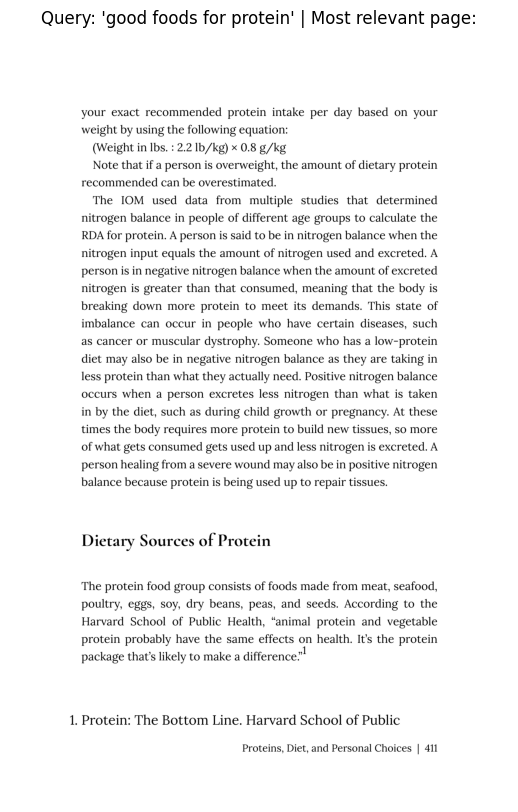

In [ ]:
import fitz

# Open PDF and load the target
pdf_path = "human-nutrition-text.pdf"
doc = fitz.open(pdf_path)
page = doc.load_page(411 + 41)

# Get the image of the page
img = page.get_pixmap(dpi = 300)

# Save image
# img.save("output_filename.png")
doc.close()

# Convert the pixmap to a numpy array
img_array = np.frombuffer(img.samples_mv,
                          dtype = np.uint8).reshape((img.h, img.w, img.n))

# Display the image using Matplotlib
import matplotlib.pyplot as plt
plt.figure(figsize = (13, 10))
plt.imshow(img_array)
plt.title(f"Query: '{query}' | Most relevant page:")
plt.axis("off")
plt.show()

### **2.3. Similarity measures: dot product and cosine similarity:**

- Two of the most common similarity measures betweeon vectors are **Dot Product** and **Cosine Similarity**
- In essence, closer vectors will have higher scores
- Further, away vectors will have lower scores

Vectors have direction (which way is it going?) and magnitude (how long is it?).

In [ ]:
import torch

def dot_product(vector1, vector2):
    return torch.dot(vector1, vector2)

def cosine_similarity(vector1, vector2):
    dot_product = torch.dot(vector1, vector2)

    # Get Euclidean/L2 norm
    norm_vector1 = torch.sqrt(torch.sum(vector1**2))
    norm_vector2 = torch.sqrt(torch.sum(vector2**2))

    return dot_product / (norm_vector1 * norm_vector2)

# Example vectors/tensors
vector1 = torch.tensor([1, 2, 3], dtype=torch.float32)
vector2 = torch.tensor([1, 2, 3], dtype=torch.float32)
vector3 = torch.tensor([4, 5, 6], dtype=torch.float32)
vector4 = torch.tensor([-1, -2, -3], dtype=torch.float32)

# Calculate dot product
print("Dot product between vector1 and vector2:", dot_product(vector1, vector2))
print("Dot product between vector1 and vector3:", dot_product(vector1, vector3))
print("Dot product between vector1 and vector4:", dot_product(vector1, vector4))

# Cosine similarity
print("Cosine similarity between vector1 and vector2:", cosine_similarity(vector1, vector2))
print("Cosine similarity between vector1 and vector3:", cosine_similarity(vector1, vector3))
print("Cosine similarity between vector1 and vector4:", cosine_similarity(vector1, vector4))

Dot product between vector1 and vector2: tensor(14.)
Dot product between vector1 and vector3: tensor(32.)
Dot product between vector1 and vector4: tensor(-14.)
Cosine similarity between vector1 and vector2: tensor(1.0000)
Cosine similarity between vector1 and vector3: tensor(0.9746)
Cosine similarity between vector1 and vector4: tensor(-1.0000)


### **2.4. Functionizing our semantic search pipeline:**

In [ ]:
def retrieve_relevant_resources(query: str,
                                embeddings: torch.tensor,
                                model: SentenceTransformer=embedding_model,
                                n_resources_to_return: int=5,
                                print_time: bool=True):
    """
    Embeds a query with model and returns top k scores and indices from embeddings.
    """

    # Embed the query
    query_embedding = model.encode(query, convert_to_tensor=True)

    # Get dot product scores on embeddings
    start_time = timer()
    dot_scores = util.dot_score(query_embedding, embeddings)[0]
    end_time = timer()

    if print_time:
        print(f"[INFO] Time taken to get scores on ({len(embeddings)} embeddings: {end_time-start_time:.5f} seconds.")

    scores, indices = torch.topk(input=dot_scores,
                                 k=n_resources_to_return)

    return scores, indices

def print_top_results_and_scores(query: str,
                                 embeddings: torch.tensor,
                                 pages_and_chunks: list[dict]=pages_and_chunks,
                                 n_resources_to_return: int=5):
    """
    Finds relevant passages given a query and prints them out along with their scores.
    """
    scores, indices = retrieve_relevant_resources(query=query,
                                                  embeddings=embeddings,
                                                  n_resources_to_return=n_resources_to_return)

    # Loop through zipped together scores and indices from torch.topk
    for score, idx in zip(scores, indices):
        print(f"Score: {score:.4f}")
        print("Text:")
        print_wrapped(pages_and_chunks[idx]["sentence_chunk"])
        print(f"Page number: {pages_and_chunks[idx]['page_number']}")
        print("\n")

In [ ]:
query="foods high in fiber"
# retrieve_relevant_resources(query=query, embeddings=embeddings)
print_top_results_and_scores(query=query, embeddings=embeddings)

[INFO] Time taken to get scores on (1680 embeddings: 0.00006 seconds.
Score: 0.6964
Text:
• Change it up a bit and experience the taste and satisfaction of other whole
grains such as barley, quinoa, and bulgur. • Eat snacks high in fiber, such as
almonds, pistachios, raisins, and air-popped popcorn. Add an artichoke and green
peas to your dinner plate more 276 | Carbohydrates and Personal Diet Choices
Page number: 276


Score: 0.6810
Text:
Dietary fiber is categorized as either water-soluble or insoluble. Some examples
of soluble fibers are inulin, pectin, and guar gum and they are found in peas,
beans, oats, barley, and rye. Cellulose and lignin are insoluble fibers and a
few dietary sources of them are whole-grain foods, flax, cauliflower, and
avocados. Cellulose is the most abundant fiber in plants, making up the cell
walls and providing structure. Soluble fibers are more easily accessible to
bacterial enzymes in the large intestine so they can be broken down to a greater
extent tha

### **2.5. Getting an LLM for local generation:**

- We want to focus on **local generation**
- However, this process will also work with an **`LLM API`**
- What is a Generative LLM?
- `Goes from text input -> Generate text output`
- Which LLM should I use?
- How much hardware VRAM do we have available?


#### **Check our local GPU Memory Availability:**

In [ ]:
# Get GPU available memory
import torch
gpu_memory_bytes = torch.cuda.get_device_properties(0).total_memory
gpu_memory_gb = round(gpu_memory_bytes / (2**30))
print(f"Available GPU memory: {gpu_memory_gb} GB")

Available GPU memory: 15 GB


In [ ]:
# Note: the following is Gemma focused, however, there are more and more LLMs of the 2B and 7B size appearing for local use.
if gpu_memory_gb < 5.1:
    print(f"Your available GPU memory is {gpu_memory_gb}GB, you may not have enough memory to run a Gemma LLM locally without quantization.")
elif gpu_memory_gb < 8.1:
    print(f"GPU memory: {gpu_memory_gb} | Recommended model: Gemma 2B in 4-bit precision.")
    use_quantization_config = True
    model_id = "google/gemma-2b-it"
elif gpu_memory_gb < 19.0:
    print(f"GPU memory: {gpu_memory_gb} | Recommended model: Gemma 2B in float16 or Gemma 7B in 4-bit precision.")
    use_quantization_config = False
    model_id = "google/gemma-2b-it"
elif gpu_memory_gb > 19.0:
    print(f"GPU memory: {gpu_memory_gb} | Recommend model: Gemma 7B in 4-bit or float16 precision.")
    use_quantization_config = False
    model_id = "google/gemma-7b-it"

print(f"use_quantization_config set to: {use_quantization_config}")
print(f"model_id set to: {model_id}")

GPU memory: 15 | Recommended model: Gemma 2B in float16 or Gemma 7B in 4-bit precision.
use_quantization_config set to: False
model_id set to: google/gemma-2b-it


### **2.6. Large Language Model (LLM):**

- We can load an LLM locally using Hugging Face Transformers
- The model we're going to us on `Google Colab`
- We can load an LLM using Hugging Face transformers - https://huggingface.co/google/gemma-2b-it via API

#### **To get a model running locally, we need a few things:**

- A Quantization Configuration (optional): A config on what precision to load the model in (e.g. 8bit, 4bit etc.)
- A model ID: it will tell transformers which model or tokenizer to load
- A tokenizer: it turns text into numbers ready for the LLM
- A tokenizer is different from embedding model

#### **LLM Model:**

- It will be what we used to generate text based on an input!

**Note:** There are many tips and tricks on loading/making LLMs work faster. One of the best ones is flash_attn (Flash Attention 2). See the GitHub for more: https://github.com/Dao-AILab/flash-attention

In [ ]:
# !pip install -U "huggingface_hub[cli]"

In [ ]:
!huggingface-cli --help

usage: huggingface-cli <command> [<args>]

positional arguments:
  {env,login,whoami,logout,repo,upload,download,lfs-enable-largefiles,lfs-multipart-upload,scan-cache,delete-cache,tag}
                        huggingface-cli command helpers
    env                 Print information about the environment.
    login               Log in using a token from huggingface.co/settings/tokens
    whoami              Find out which huggingface.co account you are logged in as.
    logout              Log out
    repo                {create} Commands to interact with your huggingface.co repos.
    upload              Upload a file or a folder to a repo on the Hub
    download            Download files from the Hub
    lfs-enable-largefiles
                        Configure your repository to enable upload of files > 5GB.
    scan-cache          Scan cache directory.
    delete-cache        Delete revisions from the cache directory.
    tag                 (create, list, delete) tags for a repo in 

In [ ]:
!huggingface-cli login


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

    To login, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Enter your token (input will not be visible): 
Add token as git credential? (Y/n) Y
Token is valid (permission: read).
Cannot authenticate through git-credential as no helper is defined on your machine.
You might have to re-authenticate when pushing to the Hugging Face Hub.
Run the following command in your terminal in c

In [ ]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM
from transformers.utils import is_flash_attn_2_available

In [ ]:
# 1. Create a quantization config
# Note: requires !pip install bitsandbytes accelerate
from transformers import BitsAndBytesConfig
quantization_config = BitsAndBytesConfig(load_in_4bit=True,
                                         bnb_4bit_compute_dtype=torch.float16)

# Bonus: flash attention 2 = faster attention mechanism
# Flash Attention 2 requires a GPU with a compute capability score of 8.0+ (Ampere, Ada Lovelace, Hopper and above): https://developer.nvidia.com/cuda-gpus
if (is_flash_attn_2_available()) and (torch.cuda.get_device_capability(0)[0] >= 8):
    attn_implementation = "flash_attention_2"
else:
    attn_implementation = "sdpa" # scaled dot product attention
print(f"Using attention implementation: {attn_implementation}")

Using attention implementation: sdpa


In [ ]:
# 2. Pick a model we'd like to use
# model_id = "google/gemma-7b-it"
model_id = "google/gemma-2b-it"

In [ ]:
# 3. Instantiate tokenizer (tokenizer turns text into tokens)
tokenizer = AutoTokenizer.from_pretrained(pretrained_model_name_or_path=model_id)

tokenizer_config.json:   0%|          | 0.00/34.2k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/4.24M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.5M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/636 [00:00<?, ?B/s]

In [ ]:
# 4. Instantiate the model
llm_model = AutoModelForCausalLM.from_pretrained(pretrained_model_name_or_path=model_id,
                                                 torch_dtype=torch.float16,
                                                 quantization_config=quantization_config if use_quantization_config else None,
                                                 low_cpu_mem_usage=False, # use as much memory as we can
                                                 attn_implementation=attn_implementation)

if not use_quantization_config:
    llm_model.to("cuda")

config.json:   0%|          | 0.00/627 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/13.5k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.95G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/67.1M [00:00<?, ?B/s]

Gemma's activation function should be approximate GeLU and not exact GeLU.
Changing the activation function to `gelu_pytorch_tanh`.if you want to use the legacy `gelu`, edit the `model.config` to set `hidden_activation=gelu`   instead of `hidden_act`. See https://github.com/huggingface/transformers/pull/29402 for more details.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/137 [00:00<?, ?B/s]

In [ ]:
print(f"Using attention implementation: {attn_implementation}")

Using attention implementation: sdpa


In [ ]:
llm_model

GemmaForCausalLM(
  (model): GemmaModel(
    (embed_tokens): Embedding(256000, 2048, padding_idx=0)
    (layers): ModuleList(
      (0-17): 18 x GemmaDecoderLayer(
        (self_attn): GemmaSdpaAttention(
          (q_proj): Linear(in_features=2048, out_features=2048, bias=False)
          (k_proj): Linear(in_features=2048, out_features=256, bias=False)
          (v_proj): Linear(in_features=2048, out_features=256, bias=False)
          (o_proj): Linear(in_features=2048, out_features=2048, bias=False)
          (rotary_emb): GemmaRotaryEmbedding()
        )
        (mlp): GemmaMLP(
          (gate_proj): Linear(in_features=2048, out_features=16384, bias=False)
          (up_proj): Linear(in_features=2048, out_features=16384, bias=False)
          (down_proj): Linear(in_features=16384, out_features=2048, bias=False)
          (act_fn): PytorchGELUTanh()
        )
        (input_layernorm): GemmaRMSNorm()
        (post_attention_layernorm): GemmaRMSNorm()
      )
    )
    (norm): GemmaR

In [ ]:
def get_model_num_params(model: torch.nn.Module):
    return sum([param.numel() for param in model.parameters()])

get_model_num_params(llm_model)

2506172416

In [ ]:
def get_model_mem_size(model: torch.nn.Module):
    # Get model parameters and buffer sizes
    mem_params = sum([param.nelement() * param.element_size() for param in model.parameters()])
    mem_buffers = sum([buf.nelement() * buf.element_size() for buf in model.buffers()])

    # Calculate model sizes
    model_mem_bytes = mem_params + mem_buffers
    model_mem_mb = model_mem_bytes / (1024**2)
    model_mem_gb = model_mem_bytes / (1024**3)

    return {"model_mem_bytes": model_mem_bytes,
            "model_mem_mb": round(model_mem_mb, 2),
            "model_mem_gb": round(model_mem_gb, 2)}

get_model_mem_size(llm_model)

{'model_mem_bytes': 5012344832, 'model_mem_mb': 4780.14, 'model_mem_gb': 4.67}

### **2.7. Generating text with our LLM:**

- Let's generate text with our local LLM!
- Note: Some models have been trained/tuned to generate text with a specific template in mind.
- Because `gemma-2b-it` has been trained in an instruction-tuned manner, we should follow the instruction template for the best results.

In [ ]:
input_text = "What are the macronutrients and what are their functions in the body?"
print(f"Input text:\n{input_text}")

# Create prompt template for instruction-tuned model
dialogue_template = [
    {"role": "user",
     "content": input_text}
]

# Apply the chat template
prompt = tokenizer.apply_chat_template(conversation=dialogue_template,
                                       tokenize=False,
                                       add_generation_prompt=True)
print(f"\nPrompt (formatted):\n{prompt}")

Input text:
What are the macronutrients and what are their functions in the body?

Prompt (formatted):
<bos><start_of_turn>user
What are the macronutrients and what are their functions in the body?<end_of_turn>
<start_of_turn>model



In [ ]:
%%time

# Tokenize the input text (turn it into numbers) and send it to the GPU
input_ids = tokenizer(prompt,
                      return_tensors="pt").to("cuda")

# Generate outputs from local LLM
outputs = llm_model.generate(**input_ids,
                             max_new_tokens=256)
print(f"Model output (tokens):\n{outputs[0]}\n")

Model output (tokens):
tensor([     2,      2,    106,   1645,    108,   1841,    708,    573, 186809,
        184592,    578,   1212,    708,   1024,   7257,    575,    573,   2971,
        235336,    107,    108,    106,   2516,    108,  21404, 235269,   1517,
        235303, 235256,    476,  25497,    576,    573, 186809, 184592,    578,
          1024,   7257,    575,    573,   2971, 235292,    109,    688,  12298,
          1695, 184592,  66058,    109, 235287,   5231, 156615,  56227,  66058,
           108,    141, 235287,  34428,   4134,    604,    573,   2971, 235303,
        235256,   5999,    578,  29703, 235265,    108,    141, 235287, 110165,
         56227,    708,    573,   2971, 235303, 235256,   1872,   4303,    576,
          4134, 235269,   5199,   2290,   6915,   5640, 235265,    108,    141,
        235287,  25280,  72780,   3707,   2343,   2127, 235269,  38317, 235269,
           578,  84475, 235265,    108, 235287,   5231,  49471,  66058,    108,
           141, 2

In [ ]:
# Decode the output tokens to text
outputs_decoded = tokenizer.decode(outputs[0])
print(f"Model output (decoded):\n{outputs_decoded}\n")

Model output (decoded):
<bos><bos><start_of_turn>user
What are the macronutrients and what are their functions in the body?<end_of_turn>
<start_of_turn>model
Sure, here's a breakdown of the macronutrients and their functions in the body:

**Macronutrients:**

* **Carbohydrates:**
    * Provide energy for the body's cells and tissues.
    * Carbohydrates are the body's main source of energy, especially during physical activity.
    * Complex carbohydrates include starches, fibers, and sugars.
* **Protein:**
    * Builds and repairs tissues, enzymes, and hormones.
    * Protein is essential for muscle growth and repair, as well as for the production of antibodies.
    * Complete proteins include animal products, legumes, nuts, and seeds.
* **Fat:**
    * Provides energy, insulation, and the production of hormones.
    * Healthy fats include olive oil, avocado, nuts, and seeds.
    * Trans fats can raise cholesterol levels and increase the risk of heart disease.

**Functions of Macronutri

In [ ]:
# Nutrition-style questions generated with GPT4
gpt4_questions = [
    "What are the macronutrients, and what roles do they play in the human body?",
    "How do vitamins and minerals differ in their roles and importance for health?",
    "Describe the process of digestion and absorption of nutrients in the human body.",
    "What role does fibre play in digestion? Name five fibre containing foods.",
    "Explain the concept of energy balance and its importance in weight management."
]

# Manually created question list
manual_questions = [
    "How often should infants be breastfed?",
    "What are symptoms of pellagra?",
    "How does saliva help with digestion?",
    "What is the RDI for protein per day?",
    "water soluble vitamins"
]

query_list = gpt4_questions + manual_questions
query_list

['What are the macronutrients, and what roles do they play in the human body?',
 'How do vitamins and minerals differ in their roles and importance for health?',
 'Describe the process of digestion and absorption of nutrients in the human body.',
 'What role does fibre play in digestion? Name five fibre containing foods.',
 'Explain the concept of energy balance and its importance in weight management.',
 'How often should infants be breastfed?',
 'What are symptoms of pellagra?',
 'How does saliva help with digestion?',
 'What is the RDI for protein per day?',
 'water soluble vitamins']

In [ ]:
import random

query = random.choice(query_list)
print(f"Query: {query}")

# Get just the scores and indices of top related results
scores, indices = retrieve_relevant_resources(query=query,
                                              embeddings=embeddings)
scores, indices

Query: What are symptoms of pellagra?
[INFO] Time taken to get scores on (1680 embeddings: 0.00009 seconds.


(tensor([0.4712, 0.3562, 0.3153, 0.3025, 0.2941], device='cuda:0'),
 tensor([ 822,  853, 1536, 1555, 1531], device='cuda:0'))

### **2.8. Augmenting our prompt with context items:**

- We have done retrieval
- We have done generation

#### **Time to augment!**

- The concept of augmenting a prompt with context items is also referred as **`prompt engineering`**.
- **`Prompt engineering`** is an active field of research and many new styles and techniques are being found out.
- However, there are a fair few techniques that work quite well.

#### **Resources:**
- https://www.promptingguide.ai/
- https://github.com/brexhq/prompt-engineering
- https://www.anthropic.com/news/prompt-engineering-for-business-performance

#### **We're going to use a couple of prompting technqiues:**

1. Give clear instructions.
2. Give a few examples of input/output (e.g. given this input, I'd like this output).
3. Give room to think (e.g. create a scratchpad/"show your working space"/"let's think step by step...".

Let's create a function to format a prompt with context items.

In [ ]:
def prompt_formatter(query: str,
                     context_items: list[dict]) -> str:
    context = "- " + "\n- ".join([item["sentence_chunk"] for item in context_items])

    base_prompt = """Based on the following context items, please answer the query.
Give yourself room to think by extracting relevant passages from the context before answering the query.
Don't return the thinking, only return the answer.
Make sure your answers are as explanatory as possible.
Use the following examples as reference for the ideal answer style.
\nExample 1:
Query: What are the fat-soluble vitamins?
Answer: The fat-soluble vitamins include Vitamin A, Vitamin D, Vitamin E, and Vitamin K. These vitamins are absorbed along with fats in the diet and can be stored in the body's fatty tissue and liver for later use. Vitamin A is important for vision, immune function, and skin health. Vitamin D plays a critical role in calcium absorption and bone health. Vitamin E acts as an antioxidant, protecting cells from damage. Vitamin K is essential for blood clotting and bone metabolism.
\nExample 2:
Query: What are the causes of type 2 diabetes?
Answer: Type 2 diabetes is often associated with overnutrition, particularly the overconsumption of calories leading to obesity. Factors include a diet high in refined sugars and saturated fats, which can lead to insulin resistance, a condition where the body's cells do not respond effectively to insulin. Over time, the pancreas cannot produce enough insulin to manage blood sugar levels, resulting in type 2 diabetes. Additionally, excessive caloric intake without sufficient physical activity exacerbates the risk by promoting weight gain and fat accumulation, particularly around the abdomen, further contributing to insulin resistance.
\nExample 3:
Query: What is the importance of hydration for physical performance?
Answer: Hydration is crucial for physical performance because water plays key roles in maintaining blood volume, regulating body temperature, and ensuring the transport of nutrients and oxygen to cells. Adequate hydration is essential for optimal muscle function, endurance, and recovery. Dehydration can lead to decreased performance, fatigue, and increased risk of heat-related illnesses, such as heat stroke. Drinking sufficient water before, during, and after exercise helps ensure peak physical performance and recovery.
\nNow use the following context items to answer the user query:
{context}
\nRelevant passages: <extract relevant passages from the context here>
User query: {query}
Answer:"""
    base_prompt = base_prompt.format(context=context,
                                     query=query)

    # Create prompt template for instruction-tuned model
    dialogue_template = [
        {"role": "user",
         "content": base_prompt}
    ]

    # Apply the chat template
    prompt = tokenizer.apply_chat_template(conversation=dialogue_template,
                                           tokenize=False,
                                           add_generation_prompt=True)

    return prompt

query = random.choice(query_list)
print(f"Query: {query}")

# Get relevant resources
scores, indices = retrieve_relevant_resources(query=query,
                                              embeddings=embeddings)

# Create a list of context items
context_items = [pages_and_chunks[i] for i in indices]

# Format our prompt
prompt = prompt_formatter(query=query,
                          context_items=context_items)
print(prompt)

Query: How do vitamins and minerals differ in their roles and importance for health?
[INFO] Time taken to get scores on (1680 embeddings: 0.00010 seconds.
<bos><start_of_turn>user
Based on the following context items, please answer the query.
Give yourself room to think by extracting relevant passages from the context before answering the query.
Don't return the thinking, only return the answer.
Make sure your answers are as explanatory as possible.
Use the following examples as reference for the ideal answer style.

Example 1:
Query: What are the fat-soluble vitamins?
Answer: The fat-soluble vitamins include Vitamin A, Vitamin D, Vitamin E, and Vitamin K. These vitamins are absorbed along with fats in the diet and can be stored in the body's fatty tissue and liver for later use. Vitamin A is important for vision, immune function, and skin health. Vitamin D plays a critical role in calcium absorption and bone health. Vitamin E acts as an antioxidant, protecting cells from damage. Vitam

In [ ]:
%%time

input_ids = tokenizer(prompt, return_tensors="pt").to("cuda")

# Generate an output of tokens
outputs = llm_model.generate(**input_ids,
                             temperature=0.7, # from 0 to 1 and the lower the value, the more deterministic the text, the higher the value, the more creative
                             do_sample=True, # whether or not to use sampling, https://huyenchip.com/2024/01/16/sampling.html
                             max_new_tokens=256)

# Turn the output tokens into text
output_text = tokenizer.decode(outputs[0])
print(f"Query: {query}")
print(f"RAG answer:\m{output_text.replace(prompt, '')}")

Query: How do vitamins and minerals differ in their roles and importance for health?
RAG answer:\m<bos>The context does not explicitly mention how vitamins and minerals differ in their roles and importance for health, so I cannot answer this question from the provided context.<eos>
CPU times: user 1.88 s, sys: 17.4 ms, total: 1.9 s
Wall time: 2.1 s


#### **Functionize our LLM Answering Feature:**

In [ ]:
def ask(query: str,
        temperature: float=0.7,
        max_new_tokens:int=256,
        format_answer_text=True,
        return_answer_only=True):
    """
    Takes a query, finds relevant resources/context and generates an answer to the query based on the relevant resources.
    """

    # RETRIEVAL
    # Get just the scores and indices of top related results
    scores, indices = retrieve_relevant_resources(query=query,
                                                  embeddings=embeddings)

    # Create a list of context items
    context_items = [pages_and_chunks[i] for i in indices]

    # Add score to context item
    for i, item in enumerate(context_items):
        item["score"] = scores[i].cpu()

    # AUGMENTATION
    # Create the prompt and format it with context items
    prompt = prompt_formatter(query=query,
                              context_items=context_items)

    # GENERATION
    # Tokenize the prompt
    input_ids = tokenizer(prompt, return_tensors="pt").to("cuda")

    # Generate an output of tokens
    outputs = llm_model.generate(**input_ids,
                                 temperature=temperature,
                                 do_sample=True,
                                 max_new_tokens=max_new_tokens)

    # Decode the tokens into text
    output_text = tokenizer.decode(outputs[0])

    # Format the answer
    if format_answer_text:
        # Replace prompt and special tokens
        output_text = output_text.replace(prompt, "").replace("<bos>", "").replace("<eos>", "")

    # Only return the answer without context items
    if return_answer_only:
        return output_text

    return output_text, context_items

In [ ]:
query = random.choice(query_list)
print(f"Query: {query}")
ask(query=query,
    temperature=0.2,
    return_answer_only=False)

Query: Explain the concept of energy balance and its importance in weight management.
[INFO] Time taken to get scores on (1680 embeddings: 0.00010 seconds.


("Sure, here's the explanation of the concept of energy balance and its importance in weight management:\n\n**Energy Balance:**\nEnergy balance refers to the overall balance of energy intake and expenditure within the body. It determines the body's energy needs and how it distributes them to various physiological processes. When energy intake is equal to energy expenditure, the body maintains a stable weight. However, when energy intake is greater than expenditure, the body stores excess energy as fat. Conversely, when energy expenditure is greater than intake, the body uses stored energy sources to maintain weight.\n\n**Importance of Energy Balance for Weight Management:**\n- **Weight Maintenance:** When energy intake is balanced with expenditure, the body maintains a stable weight.\n- **Muscle Function:** Adequate hydration ensures optimal muscle function, which is crucial for physical performance.\n- **Energy Expenditure:** Energy balance plays a significant role in regulating energ

In [ ]:
query = random.choice(query_list)
print(f"Query: {query}")

# Answer query with context and return context
answer, context_items = ask(query=query,
                            temperature=0.7,
                            max_new_tokens=512,
                            return_answer_only=False)

print(f"Answer:\n")
print_wrapped(answer)
print(f"Context items:")
context_items

Query: water soluble vitamins
[INFO] Time taken to get scores on (1680 embeddings: 0.00009 seconds.
Answer:

Sure, here are the relevant passages from the context:  **Passage 1:** >
Vitamins and minerals that make up part of enzymes are referred to as coenzymes
and cofactors, respectively. Coenzymes and cofactors are required by enzymes to
catalyze a specific reaction. They assist in converting a substrate to an end-
product.  **Passage 2:** > Vitamins and minerals that take part in metabolism
and blood function and renewal are required for energy metabolism. At
insufficient levels in the diet these vitamins and minerals impair the health of
blood and consequently the delivery of nutrients in and wastes out, amongst its
many other functions.  **Passage 3:** > Water-soluble vitamins act in the
cytosol of cells or in extracellular fluids such as blood; fat-soluble vitamins
are largely responsible for protecting cell membranes from free radical damage.
Context items:


[{'page_number': 592,
  'sentence_chunk': 'recommended that users complete these activities using a desktop or laptop computer and in Google Chrome. \xa0 An interactive or media element has been excluded from this version of the text. You can view it online here: http:/ /pressbooks.oer.hawaii.edu/ humannutrition2/?p=347 \xa0 592 | Water-Soluble Vitamins',
  'chunk_char_count': 306,
  'chunk_word_count': 45,
  'chunk_token_count': 76.5,
  'embedding': array([ 1.31825311e-02, -5.76655753e-02, -5.24329953e-03, -2.93033267e-03,
          4.46129739e-02,  2.92155873e-02,  2.06981711e-02,  2.26659495e-02,
          8.79949108e-02,  2.06947071e-03, -3.64047615e-03,  4.82459664e-02,
         -6.89612643e-04, -2.15124600e-02, -2.46340106e-03, -2.21591089e-02,
         -1.44984135e-02,  2.34625731e-02, -2.20572762e-02,  1.16169238e-02,
         -3.23735672e-04,  8.18866771e-03,  6.48807874e-03, -6.07292401e-03,
          2.90775369e-03,  2.08477192e-02,  2.59447377e-02,  1.03110177e-02,
        